# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV, ElasticNet
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qrt-2023/X_train_NHkHMNU.csv
/kaggle/input/qrt-2023/y_train_ZAN5mwg.csv
/kaggle/input/testset/X_test_final.csv


## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [93]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('/kaggle/input/qrt-2023/X_train_NHkHMNU.csv')
Y_train = pd.read_csv('/kaggle/input/qrt-2023/y_train_ZAN5mwg.csv')

X_train["TARGET"]=Y_train["TARGET"]

drop_cols=["COUNTRY","DAY_ID","FR_DE_EXCHANGE","DE_NET_IMPORT","FR_NET_IMPORT"]
X_train.drop(drop_cols,inplace=True,axis=1)

cols=['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
     'DE_HYDRO', 'FR_HYDRO',  'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET','FR_COAL','DE_NUCLEAR']





In [94]:
cols_pos=['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_GAS', 'FR_GAS', 'DE_COAL',
     'DE_HYDRO', 'FR_HYDRO',  'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET','FR_COAL','DE_NUCLEAR']

for col in cols_pos:
    X_train[col]=X_train[col]-min(X_train[col])/(max(X_train[col])-min(X_train[col]))

In [ ]:

for col in cols+['prices']:
    
     
    q1=X_train[col].quantile(0.25)
    q3=X_train[col].quantile(0.75)
    
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr

    med=np.median(X_train[col])
    
    for i in X_train[col]:
        if i > Upper_tail or i < Lower_tail:
                X_train[col] = X_train[col].replace(i, med)

this is filling Nan's with medians. 

In [95]:
for col in X_train.columns:
    if col not in ["ID","DAY_ID","COUNTRY"]:
        X_train[col]=X_train[col].fillna(X_train[col].median())
       # X_train.loc[X_train["COUNTRY"]=="FR",col]=X_train.loc[X_train["COUNTRY"]=="FR",col].fillna(X_train.loc[X_train["COUNTRY"]=="FR",col].median())

In [67]:
X_train.dropna(inplace=True)

In [51]:
def signed_sqrt(x):
    return np.sign(x) * np.log(np.abs(x)+0.1)

#X_train_log=pd.DataFrame()
X_train[cols]=signed_sqrt(X_train[cols].values)
#X_train['prices']=Y_train['TARGET']
#X_train_log[other_cols]=signed_sqrt(X_train[other_cols].values)

## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [142]:
scalar=StandardScaler()
X_train_scaled=scalar.fit_transform(X_train.drop(['prices'],axis=1))
Y=X_train['prices']

X_training,X_testing,Y_training,Y_testing=train_test_split(X_train_scaled,Y,test_size=0.2,random_state=42)

lr = Lasso(alpha=0.001)

#lr=XGBRegressor(n_estimators=100,max_depth=7,learning_rate=0.1,random_state=42,reg_lambda=2)

#X_training = X_train.drop(['COUNTRY','prices'],axis=1)
#Y_training = X_train['prices']

lr.fit(X_training, Y_training)

output_test = lr.predict(X_training)

def metric_train(output):

    return  spearmanr(output, Y_training).correlation

print('Spearman correlation for the test set: {:.1f}%'.format(100 * metric_train(output_test) ))

#Replace with your actual feature names
#coef_dict = {}
#for coef, feat in zip(lr.coef_, X_train.drop(['COUNTRY','prices'],axis=1).columns):
#    coef_dict[feat] = coef

#coef_dict

Spearman correlation for the test set: 23.2%


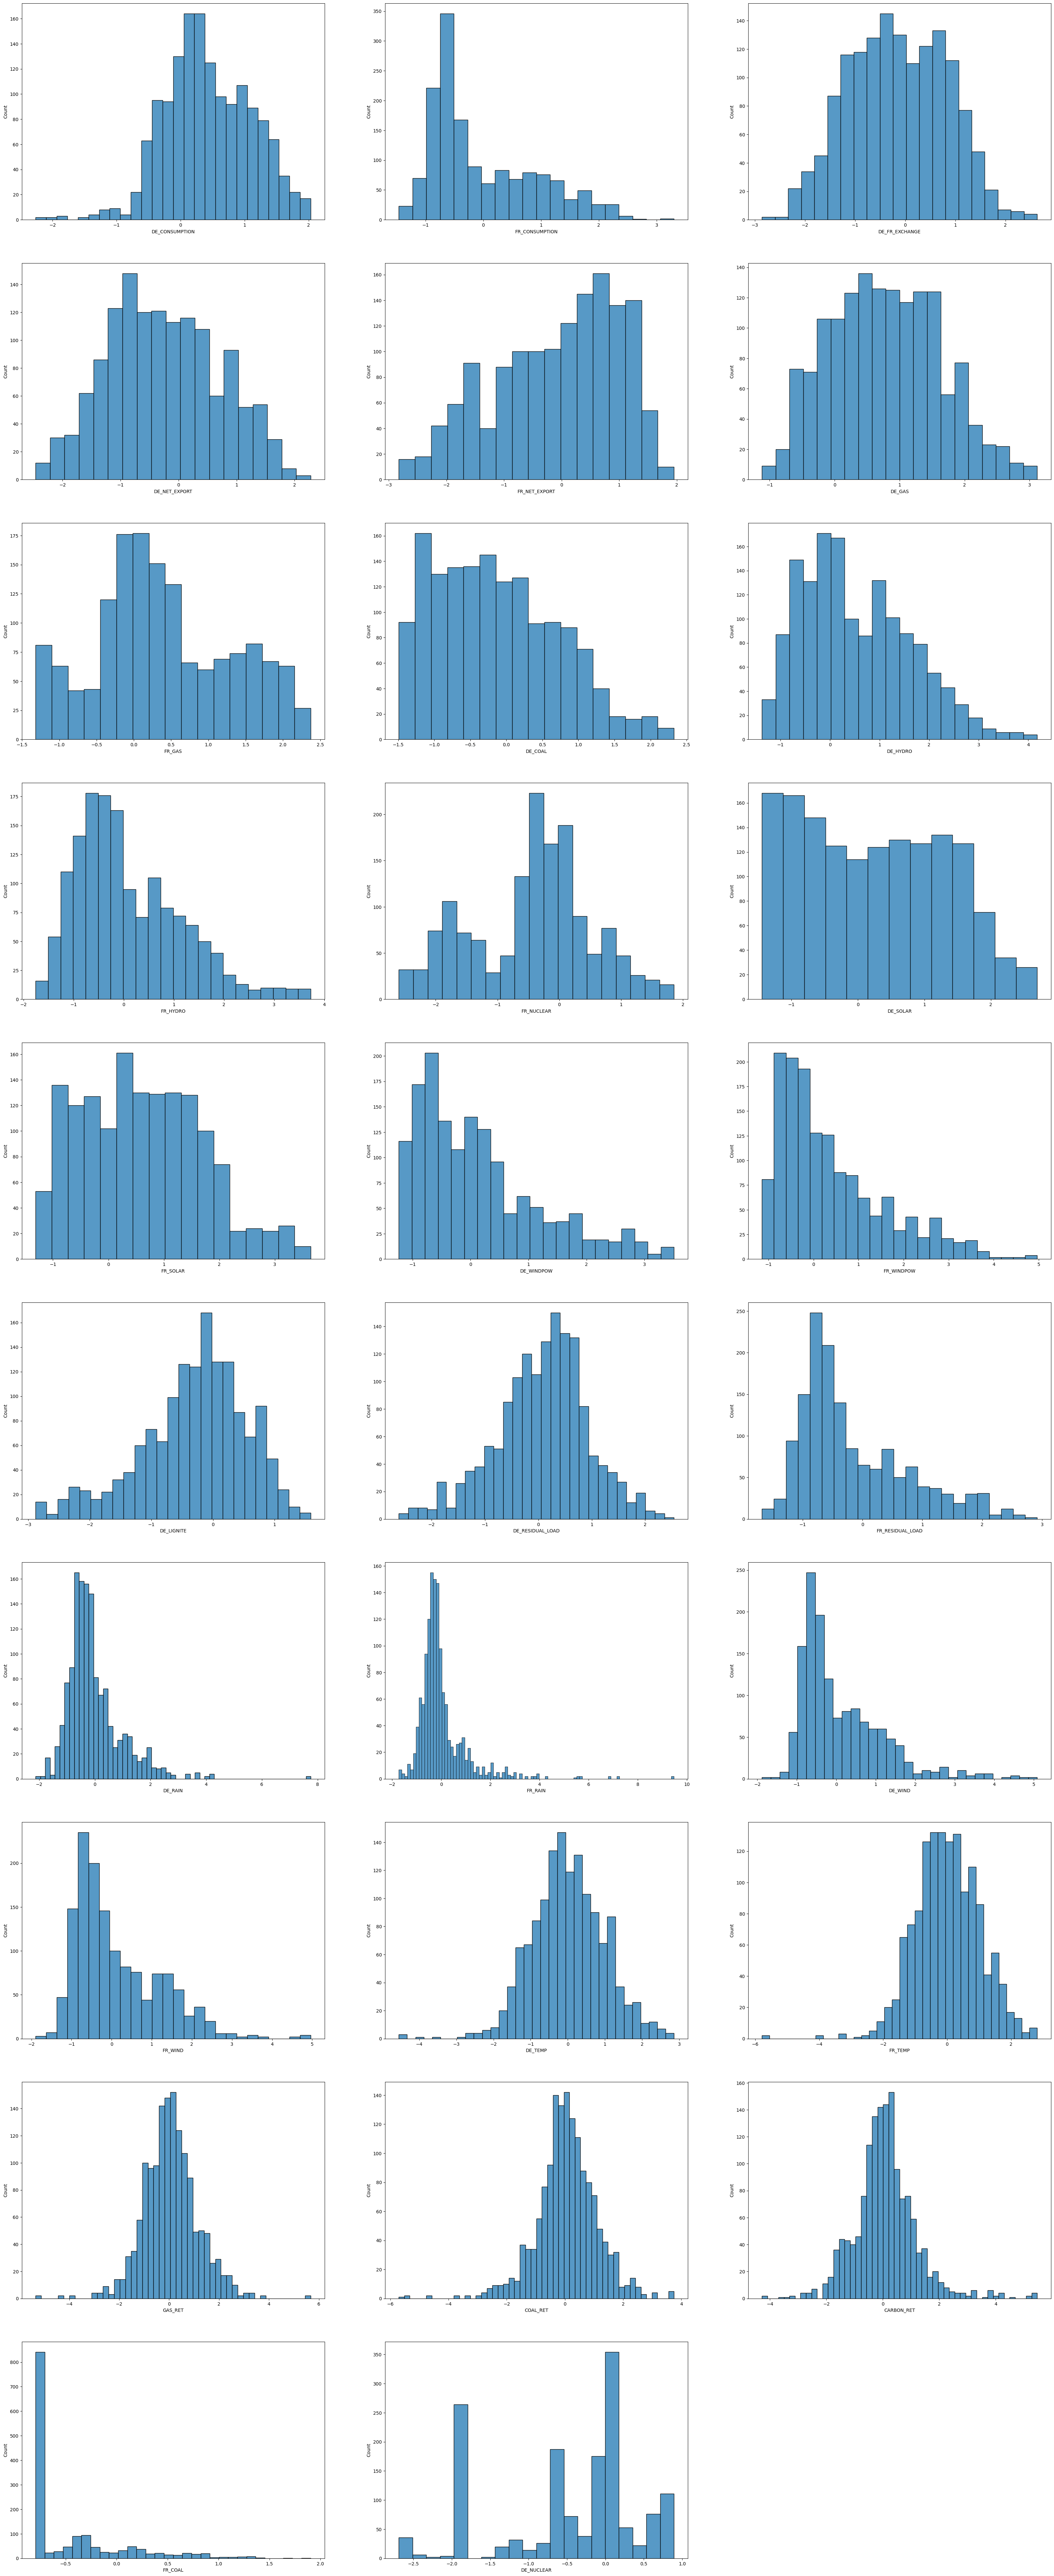

In [5]:
plt.figure(figsize=(40,100))

for i in range(len(cols)):
    plt.subplot(10,3,i+1)
    sns.histplot(x=cols[i],data=X_train)

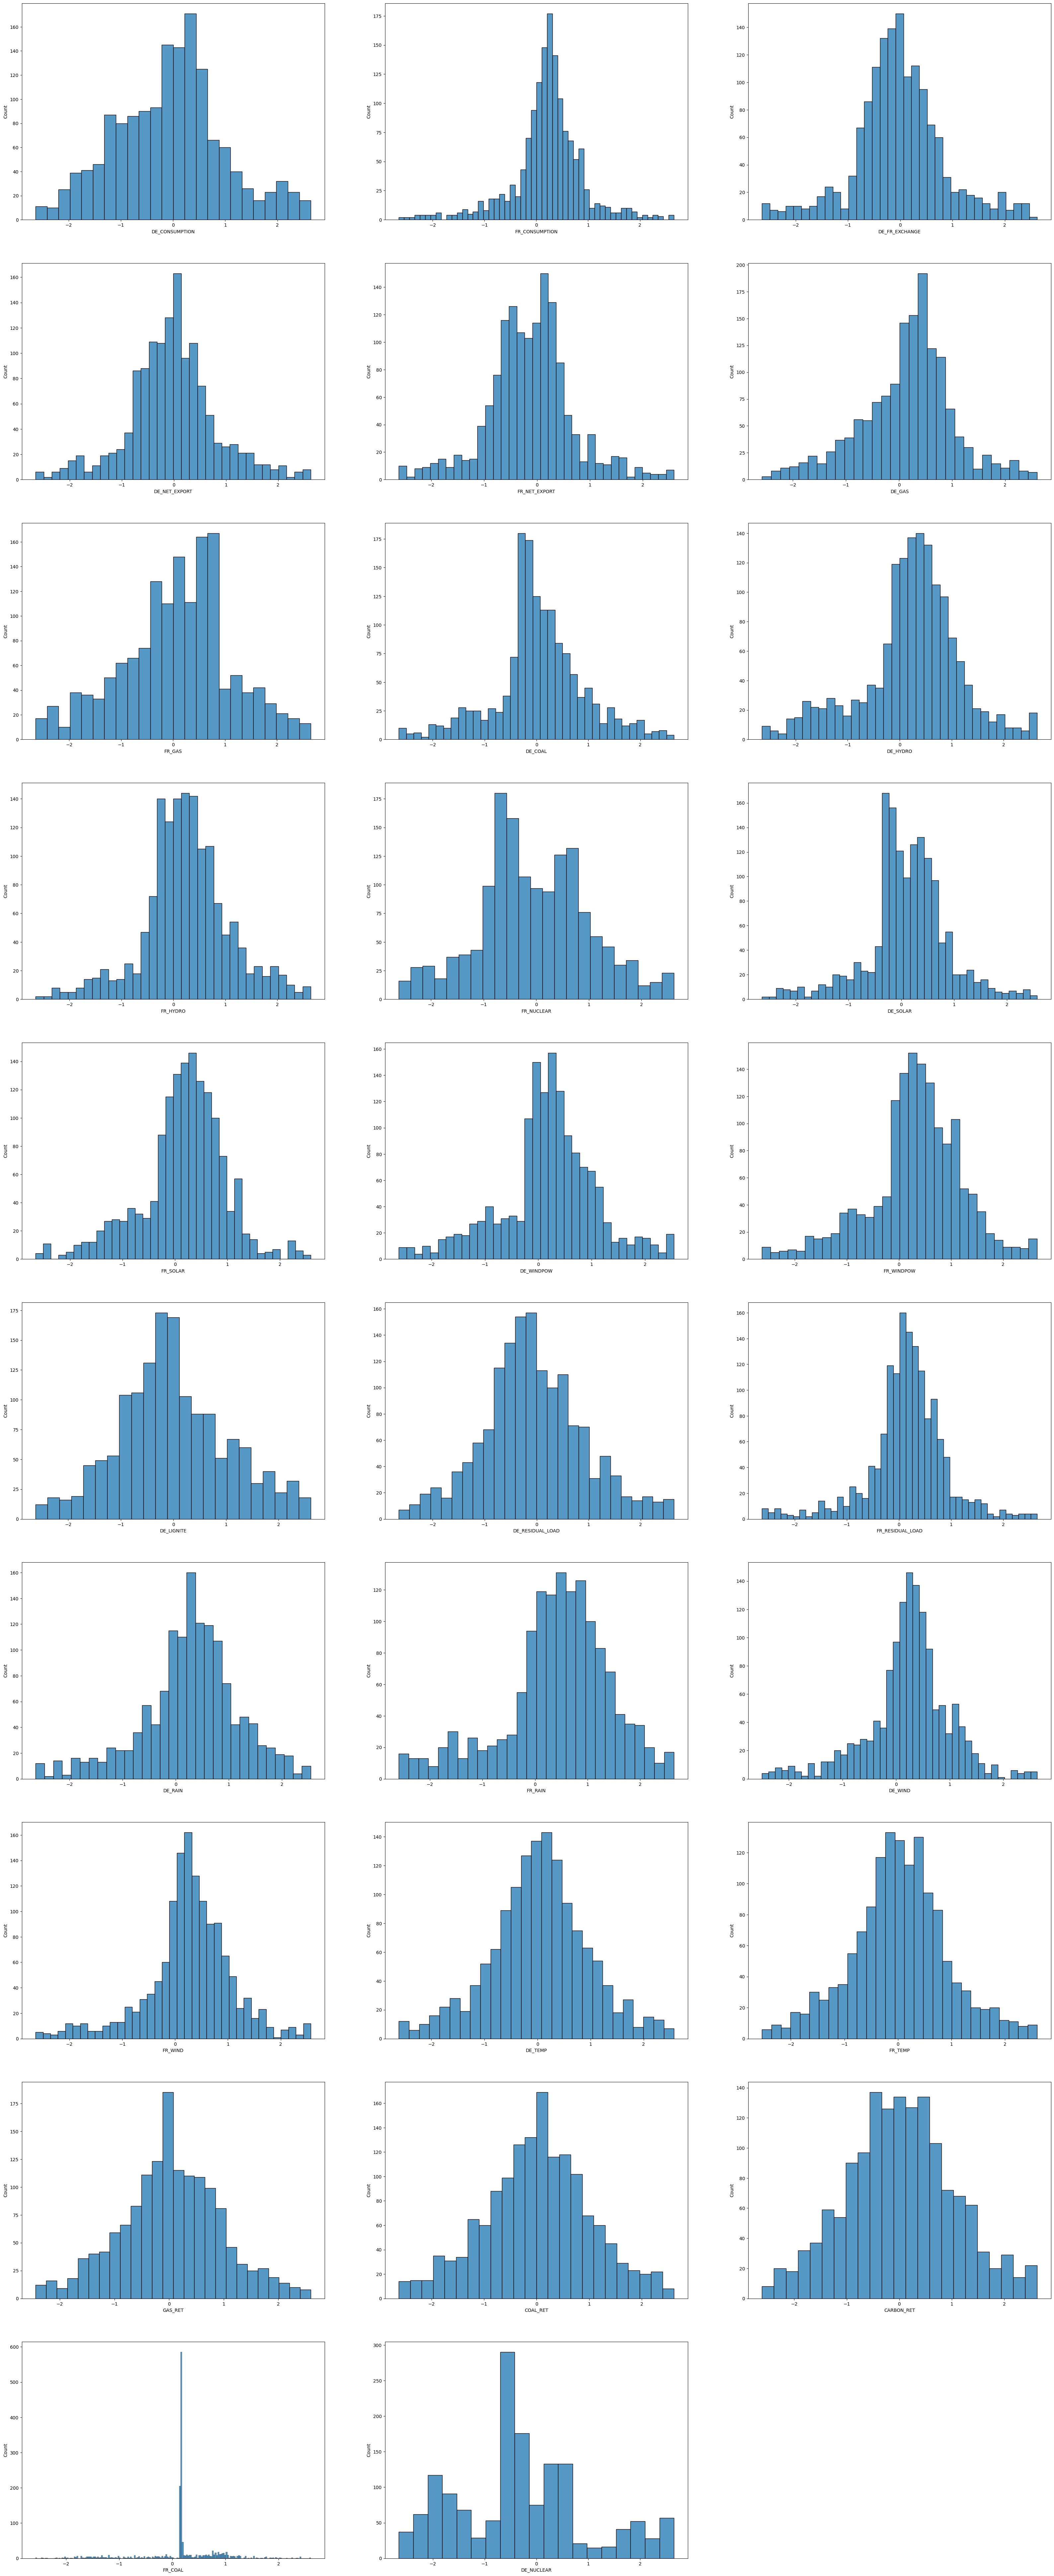

In [7]:
plt.figure(figsize=(40,100))

for i in range(len(cols)):
    plt.subplot(10,3,i+1)
    sns.histplot(x=cols[i],data=X_train_log)

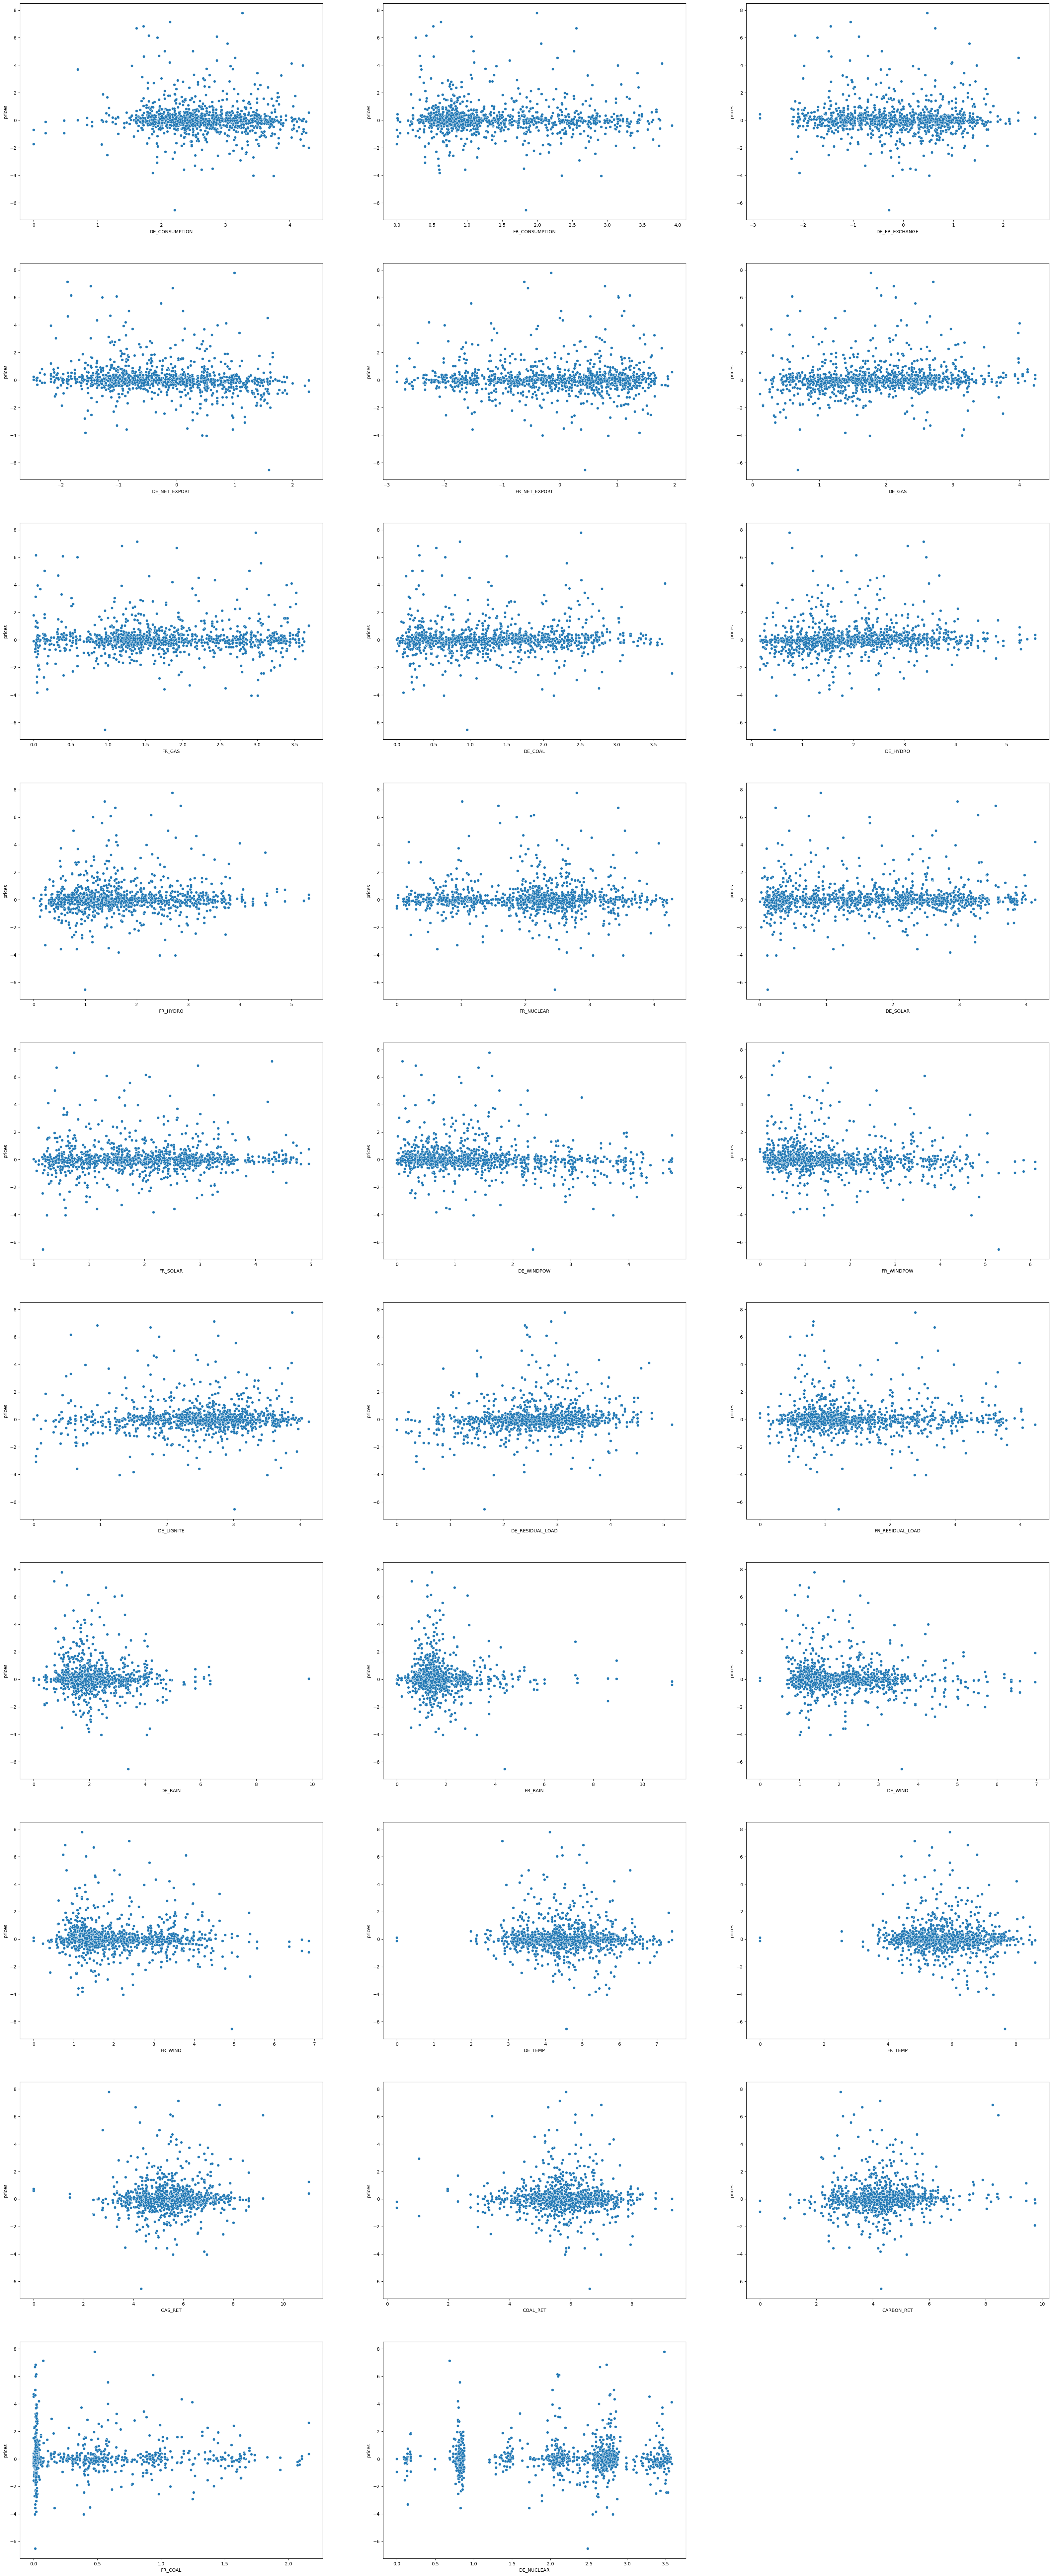

In [14]:
plt.figure(figsize=(40,100))

for i in range(len(cols)):
    plt.subplot(10,3,i+1)
    sns.scatterplot(x=cols[i],y="prices",data=X_train)

In [13]:
X_train.columns

Index(['ID', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')

In [96]:
def calculate_feature_correlation(X, y, feature_name):
    """Calculate Spearman correlation for a single feature"""
    return abs(spearmanr(X[feature_name], y)[0])

def create_ratio_features(df, feature_list):
    """Create ratio features between all pairs"""
    new_features = {}
    
    for i, feat1 in enumerate(feature_list):
        for feat2 in feature_list[i+1:]:
            # Ratio features
            ratio_name = f"{feat1}_DIV_{feat2}"
            new_features[ratio_name] = df[feat1] / (df[feat2] + 1e-2)

    return pd.DataFrame(new_features, index=df.index)
    

def create_product_features(df, feature_list,max_order=2):   

    new_features = {}
    
    # Pairwise products
    for feat1, feat2 in combinations(feature_list, 2):
        prod_name = f"{feat1}_TIMES_{feat2}"
        new_features[prod_name] = df[feat1] * df[feat2]
    
    # Triple products if max_order >= 3
    if max_order >= 3:
        for feat1, feat2, feat3 in combinations(feature_list, 3):
            prod_name = f"{feat1}_X_{feat2}_X_{feat3}"
            new_features[prod_name] = df[feat1] * df[feat2] * df[feat3]
    
    return pd.DataFrame(new_features, index=df.index)

def create_polynomial_features(df, feature_list, degree=2):
    """Create polynomial features (squares, cubes, etc.)"""
    poly_features = {}
    
    for feat in feature_list:
        for d in range(2, degree + 1):
            poly_name = f"{feat}_POW{d}"
            poly_features[poly_name] = df[feat] ** d
    
    return pd.DataFrame(poly_features, index=df.index)

def create_log_features(df, feature_list):
    """Create log-transformed features for positive values"""
    log_features = {}
    
    for feat in feature_list:
        # Log of absolute value + 1 to handle negatives and zeros
        log_name = f"LOG_{feat}"
        log_features[log_name] = np.log(np.abs(df[feat]) + 1)
        
        # Sign-preserving log
        sign_log_name = f"SIGNLOG_{feat}"
        log_features[sign_log_name] = np.sign(df[feat]) * np.log(np.abs(df[feat]) + 1)
    
    return pd.DataFrame(log_features, index=df.index)

def create_sqrt_features(df, feature_list):
    """Create square root features"""
    sqrt_features = {}
    
    for feat in feature_list:
        # Sqrt of absolute value
        sqrt_name = f"SQRT_{feat}"
        sqrt_features[sqrt_name] = np.sqrt(np.abs(df[feat]))
        
        # Sign-preserving sqrt
        sign_sqrt_name = f"SIGNSQRT_{feat}"
        sqrt_features[sign_sqrt_name] = np.sign(df[feat]) * np.sqrt(np.abs(df[feat]))
    
    return pd.DataFrame(sqrt_features, index=df.index)


    
    

def advanced_feature_engineering(df, y):
    """
    Comprehensive feature engineering with systematic exploration
    """


    df_new = df.copy()
    
    base_features = [col for col in df_new.columns if col not in ['ID', 'COUNTRY', 'TARGET']]
    
    print(f"\n2. Base features: {len(base_features)}")
    
    # Start with base features
    df_features = df_new[base_features].copy()
    
    
    # Create polynomial features from top features
    print(f"\n4. Creating polynomial features (degree 2-3)...")
    poly_df = create_polynomial_features(df_new, base_features, degree=2)
    print(f"   Created {len(poly_df.columns)} polynomial features")
    
    # Create product/interaction features
    print(f"\n5. Creating interaction features (products)...")
    product_df = create_product_features(df_new, base_features, max_order=2)
    print(f"   Created {len(product_df.columns)} product features")
    
    # Create ratio features
    print(f"\n6. Creating ratio features...")
    ratio_df = create_ratio_features(df_new, base_features)
    print(f"   Created {len(ratio_df.columns)} ratio features")
    

    # Combine all features
    all_new_features = pd.concat([poly_df, product_df], axis=1)
   # , log_df, sqrt_df
    
    # Remove NaN and inf values
    all_new_features = all_new_features.replace([np.inf, -np.inf], np.nan)
    all_new_features = all_new_features.fillna(0)
    
    print(f"\n9. Total engineered features: {len(all_new_features.columns)}")
    
    # Quick correlation screening - keep features with |correlation| > 0.05
   # print(f"\n10. Screening features by correlation threshold...")
    good_features = []
    for col in all_new_features.columns:
        corr = abs(spearmanr(all_new_features[col], y)[0])
       
        if corr > 0.1:  # Keep features with at least 0.05 correlation
            good_features.append(col)
            
    print(f"  Kept {len(good_features)} features with |correlation| > 0.05")
    
    # Combine base features with screened engineered features
    df_combined = pd.concat([ df_features, all_new_features[good_features]], axis=1)
    
    
    return df_combined






In [97]:
df=X_train.copy()

X = advanced_feature_engineering(df, df["TARGET"])
X=X.loc[:, ~X.columns.duplicated()]
#X_de = df_de_features.drop([ 'COUNTRY'], axis=1)
y = df['TARGET']


2. Base features: 29

4. Creating polynomial features (degree 2-3)...
   Created 29 polynomial features

5. Creating interaction features (products)...
   Created 406 product features

6. Creating ratio features...
   Created 406 ratio features

9. Total engineered features: 435
  Kept 41 features with |correlation| > 0.05


In [60]:
X.columns

Index(['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT',
       'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'DE_GAS_POW2', 'DE_HYDRO_POW2', 'DE_WINDPOW_POW2', 'FR_WINDPOW_POW2',
       'DE_CONSUMPTION_TIMES_DE_NET_EXPORT', 'DE_CONSUMPTION_TIMES_DE_HYDRO',
       'DE_CONSUMPTION_TIMES_DE_WINDPOW', 'DE_CONSUMPTION_TIMES_FR_WINDPOW',
       'DE_CONSUMPTION_TIMES_DE_RESIDUAL_LOAD', 'DE_NET_EXPORT_TIMES_DE_GAS',
       'DE_NET_EXPORT_TIMES_FR_GAS', 'DE_NET_EXPORT_TIMES_DE_WINDPOW',
       'DE_NET_EXPORT_TIMES_DE_TEMP', 'DE_NET_EXPORT_TIMES_COAL_RET',
       'DE_NET_EXPORT_TIMES_CARBON_RET', 'DE_GAS_TIMES_DE_HYDRO',
       'DE_GAS_TIMES_DE_WINDPOW', 'DE_GAS_TIMES_DE

In [77]:
X_de = advanced_feature_engineering(df_de, 'DE', df_de["TARGET"])
X_de=X_de.loc[:, ~X_de.columns.duplicated()]
#X_de = df_de_features.drop([ 'COUNTRY'], axis=1)
y_de = df_de['TARGET']

X_fr = advanced_feature_engineering(df_fr, 'FR', df_fr["TARGET"])
X_fr=X_fr.loc[:, ~X_fr.columns.duplicated()]
#X_fr = df_fr_features.drop([ 'COUNTRY'], axis=1)
y_fr = df_fr['TARGET']


    


Advanced Feature Engineering for DE

2. Base features: 29

4. Creating polynomial features (degree 2-3)...
   Created 29 polynomial features

5. Creating interaction features (products)...
   Created 406 product features

6. Creating ratio features...
   Created 406 ratio features

9. Total engineered features: 435
  Kept 118 features with |correlation| > 0.05

Advanced Feature Engineering for FR

2. Base features: 29

4. Creating polynomial features (degree 2-3)...
   Created 29 polynomial features

5. Creating interaction features (products)...
   Created 406 product features

6. Creating ratio features...
   Created 406 ratio features

9. Total engineered features: 435
  Kept 114 features with |correlation| > 0.05


In [98]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.decomposition import PCA

#X_scaled_de=RobustScaler().fit_transform(X_de)
#X_scaled_fr=RobustScaler().fit_transform(X_fr)

X_scaled=RobustScaler().fit_transform(X)

In [99]:
X_train1,X_test,Y_train1,Y_test= train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [100]:
model=Lasso(alpha=0.19)

model.fit(X_train1,Y_train1)

y_pred=model.predict(X_test)

print(spearmanr(y_pred,Y_test).correlation)

0.1336507831051059


In [120]:


model_de=ElasticNet(alpha=0.282671518082979,l1_ratio=0.30702906297578497)

model_de.fit(X_train,Y_train)

y_pred_de=model_de.predict(X_test)

print(spearmanr(y_pred_de,Y_test).correlation)

#model_de.coef_

0.37187304673935684


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -8.69425426e-05,  0.00000000e+00, -0.00000000e+00, -2.29689311e-03,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.31392893e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [101]:
def spearman_scorer(y_true, y_pred):
    """Spearman correlation as a scoring function"""
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

# Create scorer object
spearman_score = make_scorer(spearman_scorer, greater_is_better=True)

# Use GridSearchCV instead of RidgeCV
param_grid = {'alpha': np.logspace(-1, 1.2, 40),'l1_ratio' : np.logspace(-2, 0, 40) }
scores={}

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:

        model=ElasticNet(alpha=alpha,l1_ratio=l1_ratio)
        model.fit(X_train1,Y_train1)
        y_pred=model.predict(X_test)
        scores[spearman_scorer(Y_test,y_pred)]=(alpha,l1_ratio)


(max(scores.keys()),scores[max(scores.keys())])

(np.float64(0.23182390203997988),
 (np.float64(2.5719138090593456), np.float64(0.012663801734674034)))

In [121]:
X_train,X_test,Y_train,Y_test= train_test_split(X_scaled_fr,y_fr,test_size=0.2,random_state=42)

In [124]:

model_fr=ElasticNet(alpha=1.7419097138259692,l1_ratio=0.018047217668271703)

model_fr.fit(X_train,Y_train)

y_pred_fr=model_fr.predict(X_test)

print(spearmanr(y_pred_fr,Y_test).correlation)

model_fr.coef_

0.33541021616819927


array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.43675331e-03,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -2.20758294e-03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.45560351e-03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.42698777e-02,  0.00000000e+00, -1.26773174e-03, -0.00000000e+00,
        6.32186919e-03,  2.15481674e-02, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -2.94279163e-03, -0.00000000e+00,
       -2.99330436e-03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -1.49806765e-03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

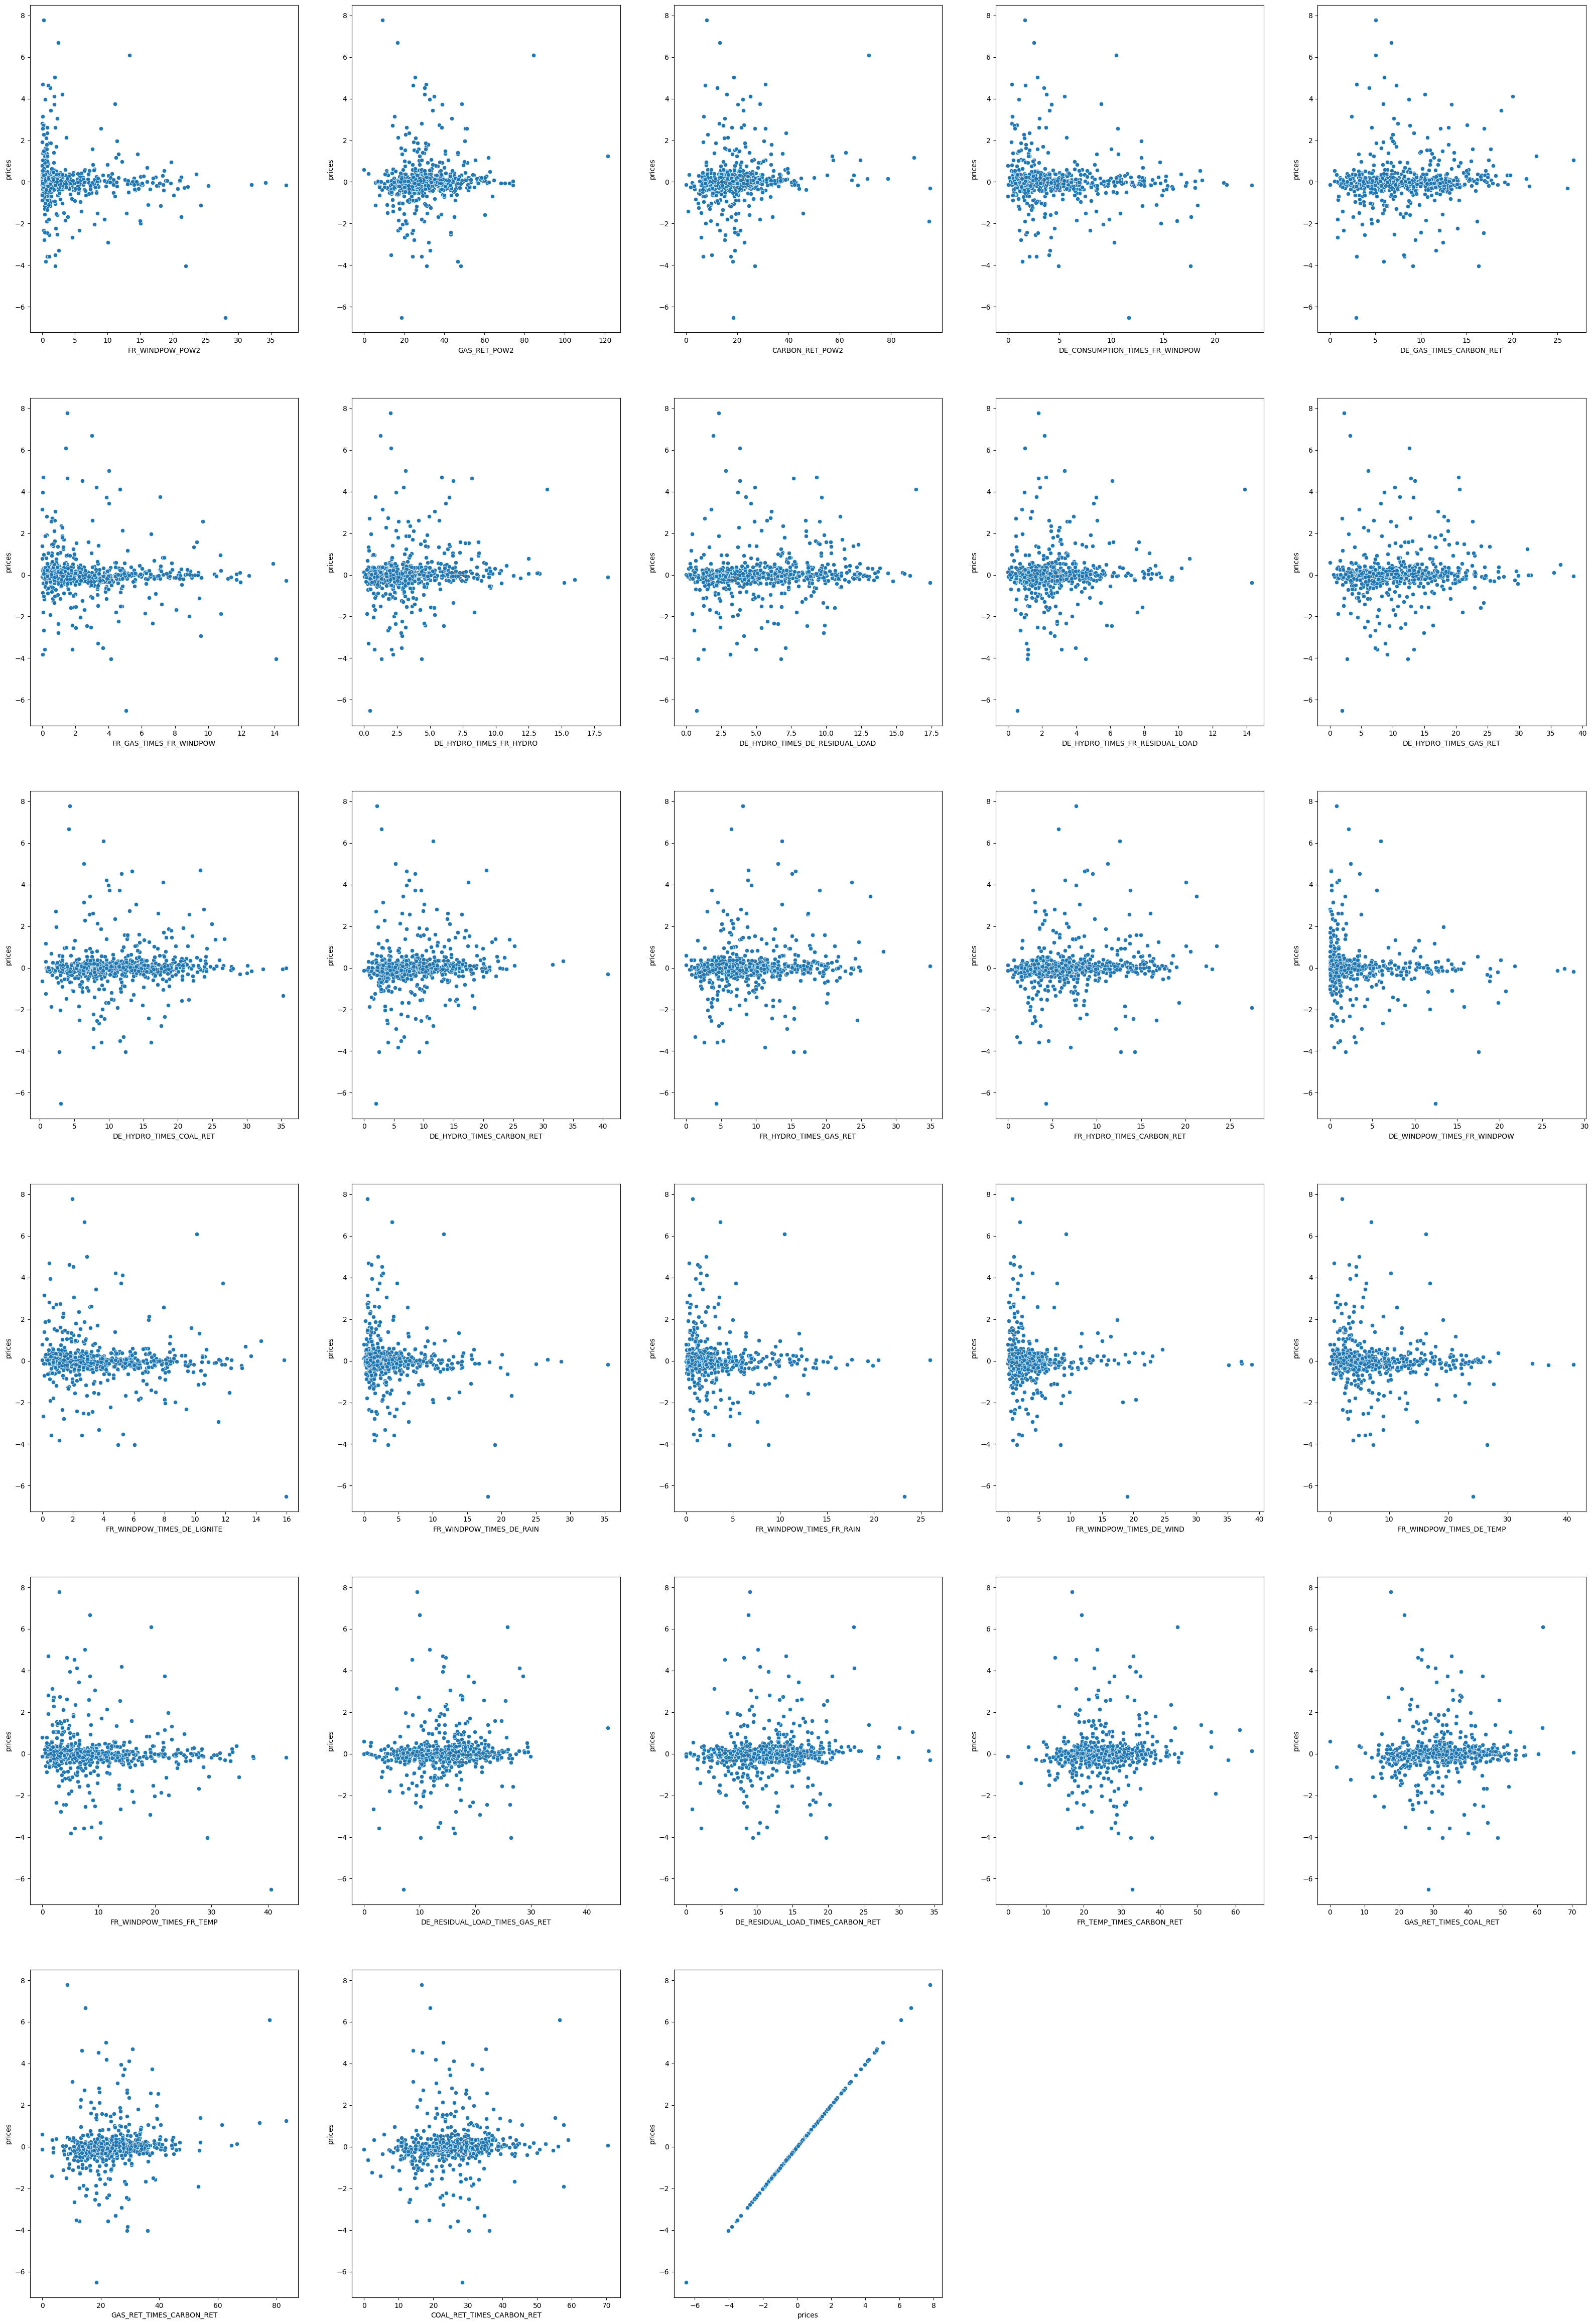

In [82]:

plt.figure(figsize=(40,100))

columns=X_fr.columns

for i in range(len(columns)):
    plt.subplot(10,5,i+1)
    sns.scatterplot(x=columns[i],y="prices",data=X_fr)

<Axes: >

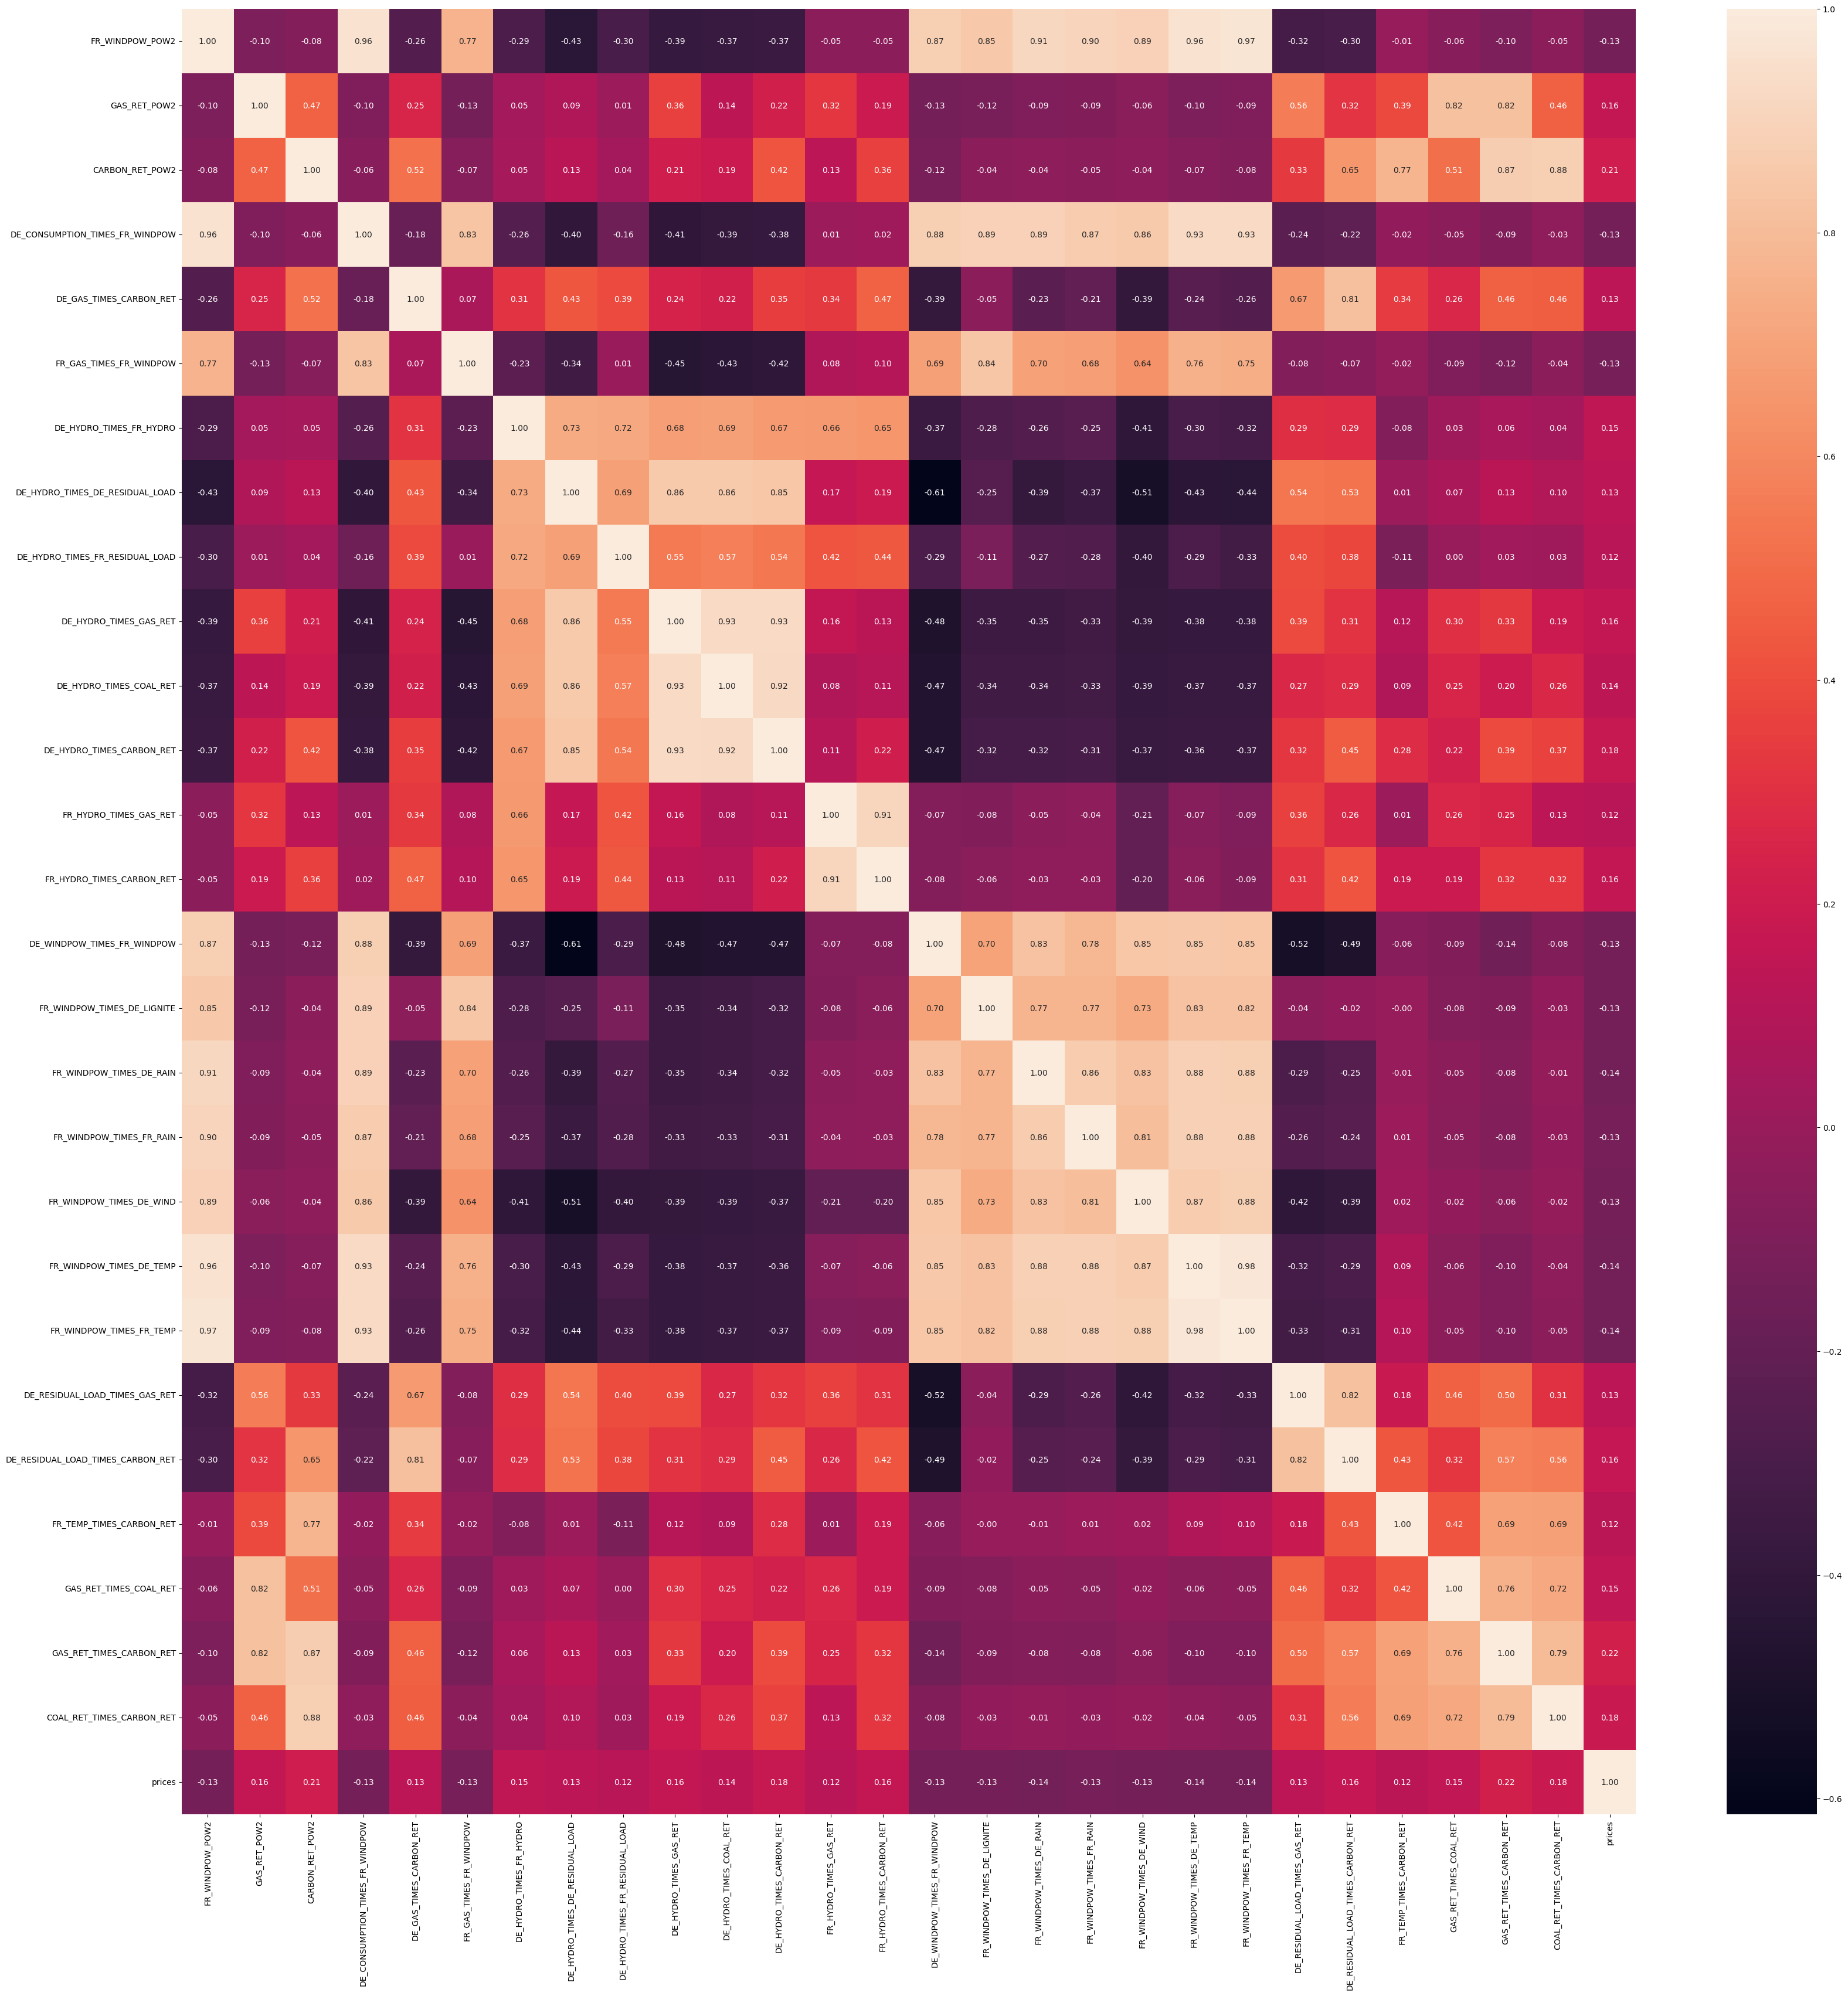

In [83]:
import seaborn as sns

corr_mat=X_fr[columns].corr(method="spearman")

plt.figure(figsize=(40,40))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

<Axes: >

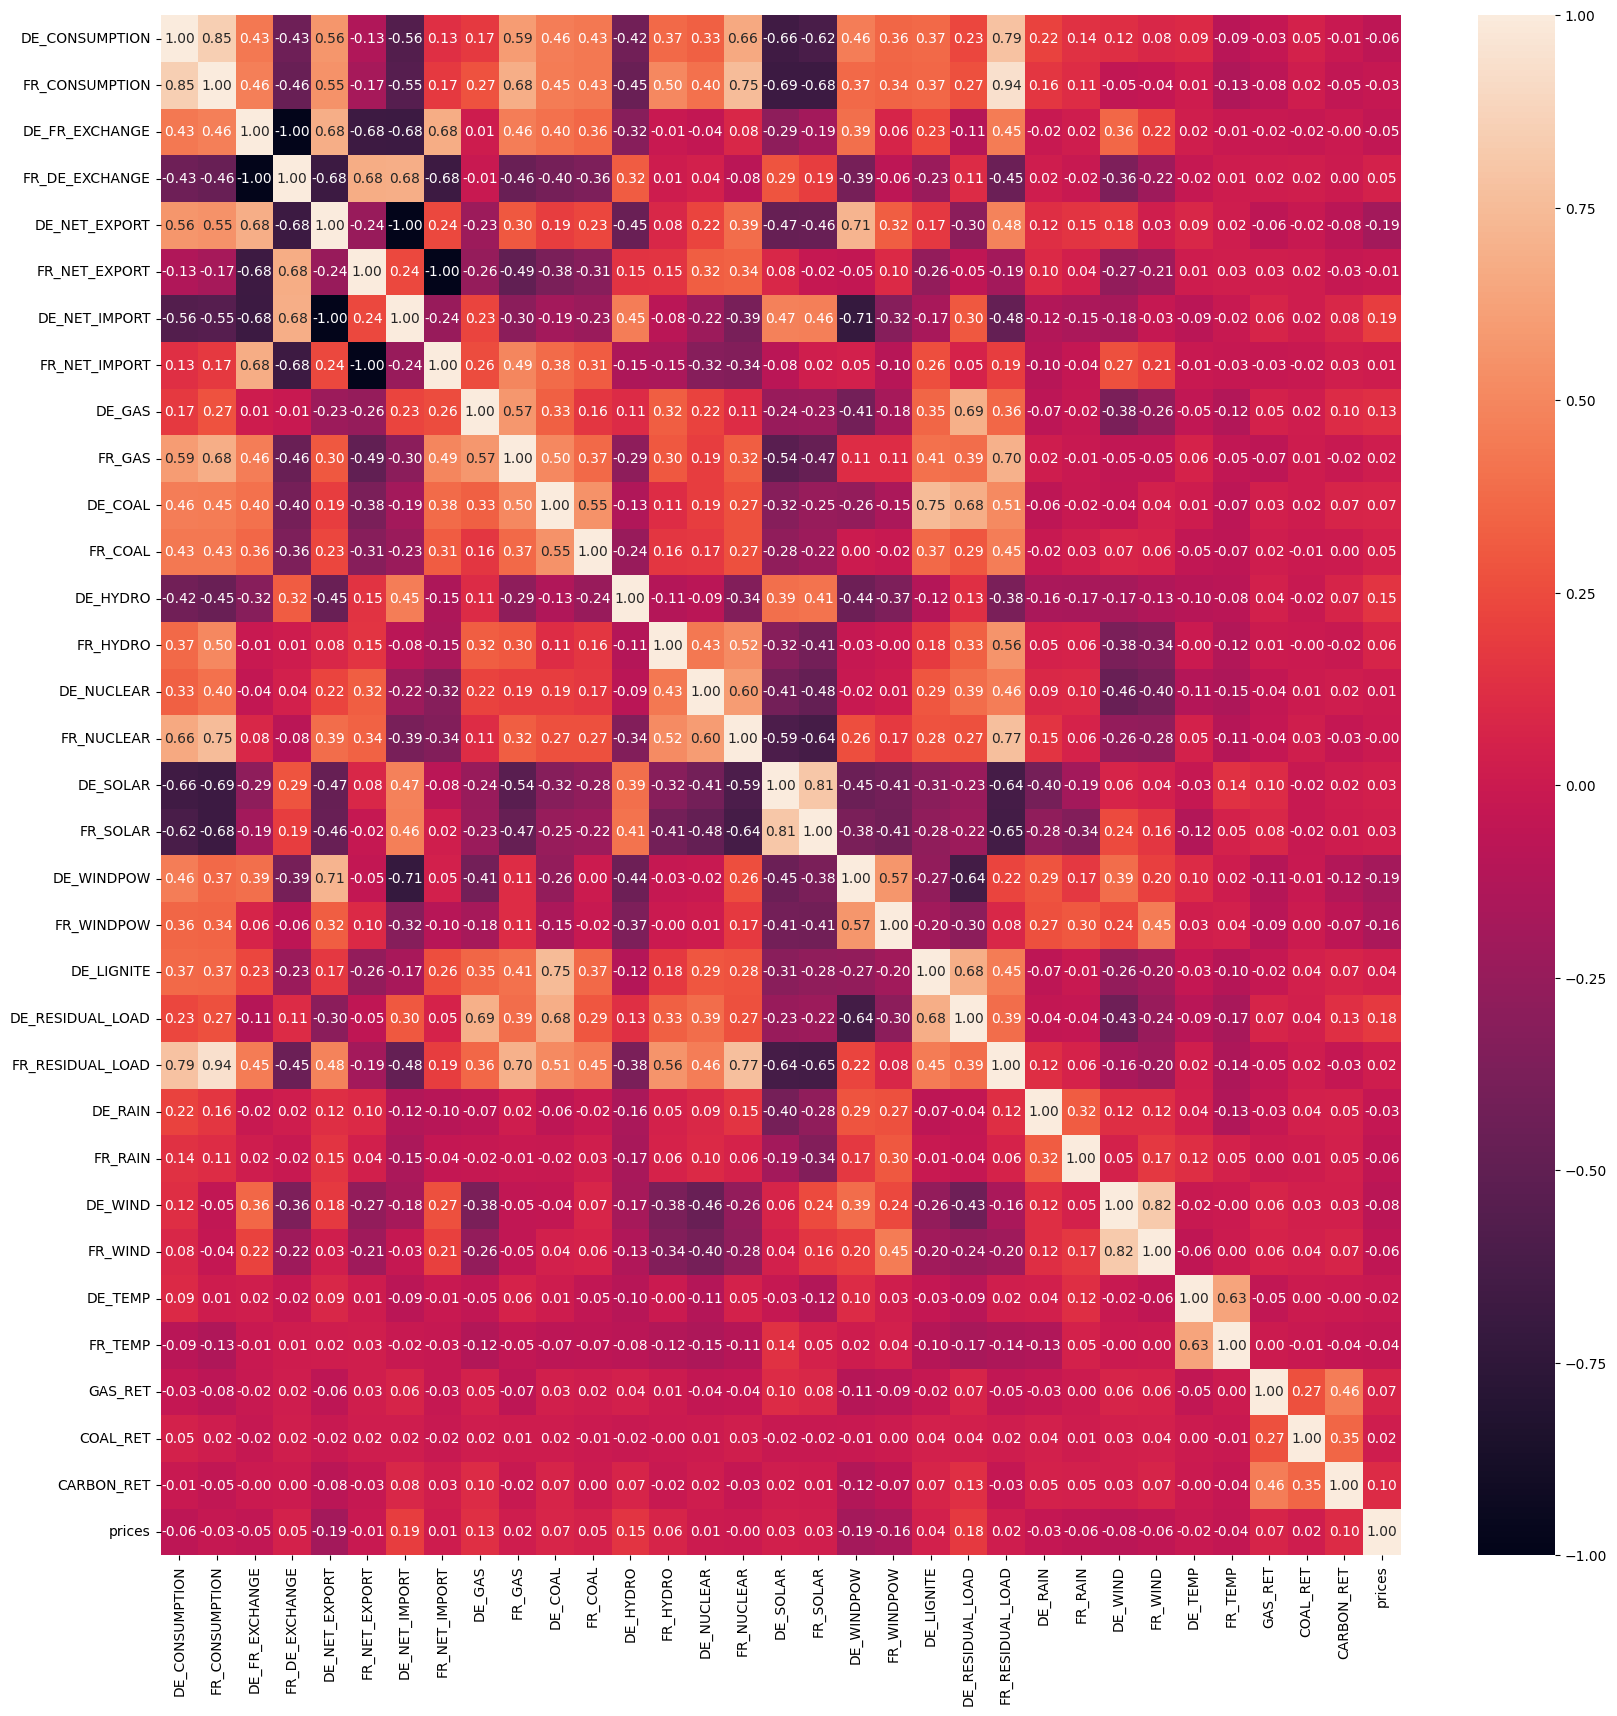

In [6]:
import seaborn as sns

corr_mat=X_train.drop(["ID","DAY_ID","COUNTRY"],axis=1).corr(method="spearman")

plt.figure(figsize=(20,20))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

In [9]:
X_train.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'prices'],
      dtype='object')

dropping NaN gives a better score than not dropping them

In [19]:
alphas = np.logspace(-1, 2, 20)  # 50 values from 0.001 to 1000
lr = RidgeCV(alphas=alphas, cv=5, scoring='r2')
lr.fit(X_train_scaled, Y)

print(f"Best alpha: {lr.alpha_}")
print(f"R² with best alpha: {lr.score(X_train_scaled, Y):.4f}")

Best alpha: 100.0
R² with best alpha: 0.0684


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNet

def spearman_scorer(y_true, y_pred):
    """Spearman correlation as a scoring function"""
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

# Create scorer object
spearman_score = make_scorer(spearman_scorer, greater_is_better=True)

# Use GridSearchCV instead of RidgeCV
#param_grid = {'alpha': np.logspace(0, 1, 1000)    }
#model = Ridge()

param_grid = {
    'max_depth': [5,6,7],
    'learning_rate': [0.05,0.1,0.2,0.3,0.4],
    'n_estimators': [100],
   # 'subsample': [0.8, 1.0],
   # 'colsample_bytree': [0.8, 1.0],
    'reg_lambda':[2,4,6]
}

model=xgb.XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring=spearman_score,
    return_train_score=True
)

grid_search.fit(X_train_log.drop(['prices'],axis=1), Y)

print(f"Best alpha: {grid_search.best_params_}")
print(f"Best Spearman correlation: {grid_search.best_score_:.4f}")

Best alpha: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 4}
Best Spearman correlation: 0.2306


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [206]:
X_test = pd.read_csv('/kaggle/input/testset/X_test_final.csv')
#Y_test_submission = X_test[['ID']].copy()
X_test.drop(drop_cols,inplace=True,axis=1)

for col in cols_pos:
    X_test[col]=X_test[col]-min(X_test[col])

In [207]:
X_test.columns

Index(['ID', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

In [208]:
for col in X_test.drop(["ID"],axis=1).columns:
    X_test[col]=X_test[col].fillna(X_test[col].median())

In [209]:
X_test.head()

ID  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  DE_NET_EXPORT  \
0  1115        7.773394        4.157407       -0.423521       0.165333   
1  1202        8.236520        5.371422        0.601610       0.342802   
2  1194        8.228851        5.312966        1.179158       1.620928   
3  1084        7.605866        3.867584       -0.044539      -0.235460   
4  1135        8.383025        5.011247        0.617391       0.608561   

   FR_NET_EXPORT    DE_GAS    FR_GAS   DE_COAL   FR_COAL  ...  \
0       0.519419  3.023218  1.747358  3.575907  1.273374  ...   
1       0.555367  2.562356  3.130769  1.528424  0.002838  ...   
2       0.666901  1.626258  1.280213  0.609345  0.009797  ...   
3      -0.205276  2.544323  1.149363  2.327320  0.511155  ...   
4      -0.240856  2.875007  2.737479  3.142526  0.555273  ...   

   FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
0          3.755499  1.406755  1.864431  0.344422  0.522031  4.850890   
1          4.835763  1.579341  1.745386  0.567152  0.177220  3.353782   
2          4.425991  2.716411  1.679231  1.703023  0.915300  4.835537   
3          3.416729  1.377329  2.033188  0.535849  0.504354  4.209551   
4          4.481591  1.689644  1.437276  0.581982  0.202381  4.146955   

    FR_TEMP   GAS_RET  COAL_RET  CARBON_RET  
0  3.167083  3.850473  4.196994    3.038384  
1  1.737345  3.532305  4.980337    4.631726  
2  2.594921  1.795412  3.900241    3.617893  
3  2.932299  2.534190  6.489345    4.609709  
4  2.787398  1.061428  3.717419    3.479299  

[5 rows x 30 columns]

In [210]:
    

def advanced_feature_engineering_test(df):
    """
    Comprehensive feature engineering with systematic exploration
    """
 

    df_new = df.copy()
    
    base_features = [col for col in df_new.columns if col not in ['COUNTRY',"ID"]]
    
    print(f"\n2. Base features: {len(base_features)}")
    
    # Start with base features
    df_features = df_new[base_features].copy()
  #  df_features["ID"]=df_new["ID"]
    
    # Create polynomial features from top features
    print(f"\n4. Creating polynomial features (degree 2-3)...")
    poly_df = create_polynomial_features(df_new, base_features, degree=2)
    print(f"   Created {len(poly_df.columns)} polynomial features")
    
    # Create product/interaction features
    print(f"\n5. Creating interaction features (products)...")
    product_df = create_product_features(df_new, base_features, max_order=2)
    print(f"   Created {len(product_df.columns)} product features")
    

    # Combine all features
    all_new_features = pd.concat([poly_df, product_df], axis=1)
   # , log_df, sqrt_df
    
    # Remove NaN and inf values
    all_new_features = all_new_features.replace([np.inf, -np.inf], np.nan)
    all_new_features = all_new_features.fillna(0)
    
    # Combine base features with screened engineered features
    df_combined = pd.concat([df_features, all_new_features], axis=1)
    
    
    return df_combined






In [211]:
#X_test=pd.read_csv("/kaggle/input/testset/X_test_final.csv")

df1 = X_test.copy()

df1_features = advanced_feature_engineering_test(df1)

X_test_new = df1_features[X.columns]
X_test_scaled=RobustScaler().fit_transform(X_test_new)
y_pred=model.predict(X_test_scaled)

# Split by country
#df1_de = df1[df1['COUNTRY'] == 'DE'].copy()
#df1_fr = df1[df1['COUNTRY'] == 'FR'].copy()

#df1_de_features = advanced_feature_engineering_test(df1_de, 'DE')
#df1_de_features=df1_de_features.loc[:, ~df1_de_features.columns.duplicated()]
#X_test_de = df1_de_features[X_de.columns]

#df1_fr_features = advanced_feature_engineering_test(df1_fr, 'FR')
#df1_fe_features=df1_fr_features.loc[:, ~df1_fr_features.columns.duplicated()]
#X_test_fr = df1_fr_features[X_fr.columns]

#Xt_scaled_de=RobustScaler().fit_transform(X_test_de)
#Xt_scaled_fr=RobustScaler().fit_transform(X_test_fr)

#y_pred_de=model_de.predict(Xt_scaled_de)
#y_pred_fr=model_fr.predict(Xt_scaled_fr)

#predictions=pd.concat([pd.DataFrame({'ID':df1_fr['ID'],'TARGET':y_pred_fr}),pd.DataFrame({'ID':df1_de['ID'],'TARGET':y_pred_de})])

predictions=pd.DataFrame({'ID':df1['ID'],'TARGET':y_pred})
print(predictions.head())
predictions.to_csv("predictions_new.csv",index=False)




2. Base features: 29

4. Creating polynomial features (degree 2-3)...
   Created 29 polynomial features

5. Creating interaction features (products)...
   Created 406 product features
     ID    TARGET
0  1115  0.148311
1  1202  0.118029
2  1194 -0.192643
3  1084  0.189404
4  1135  0.111551


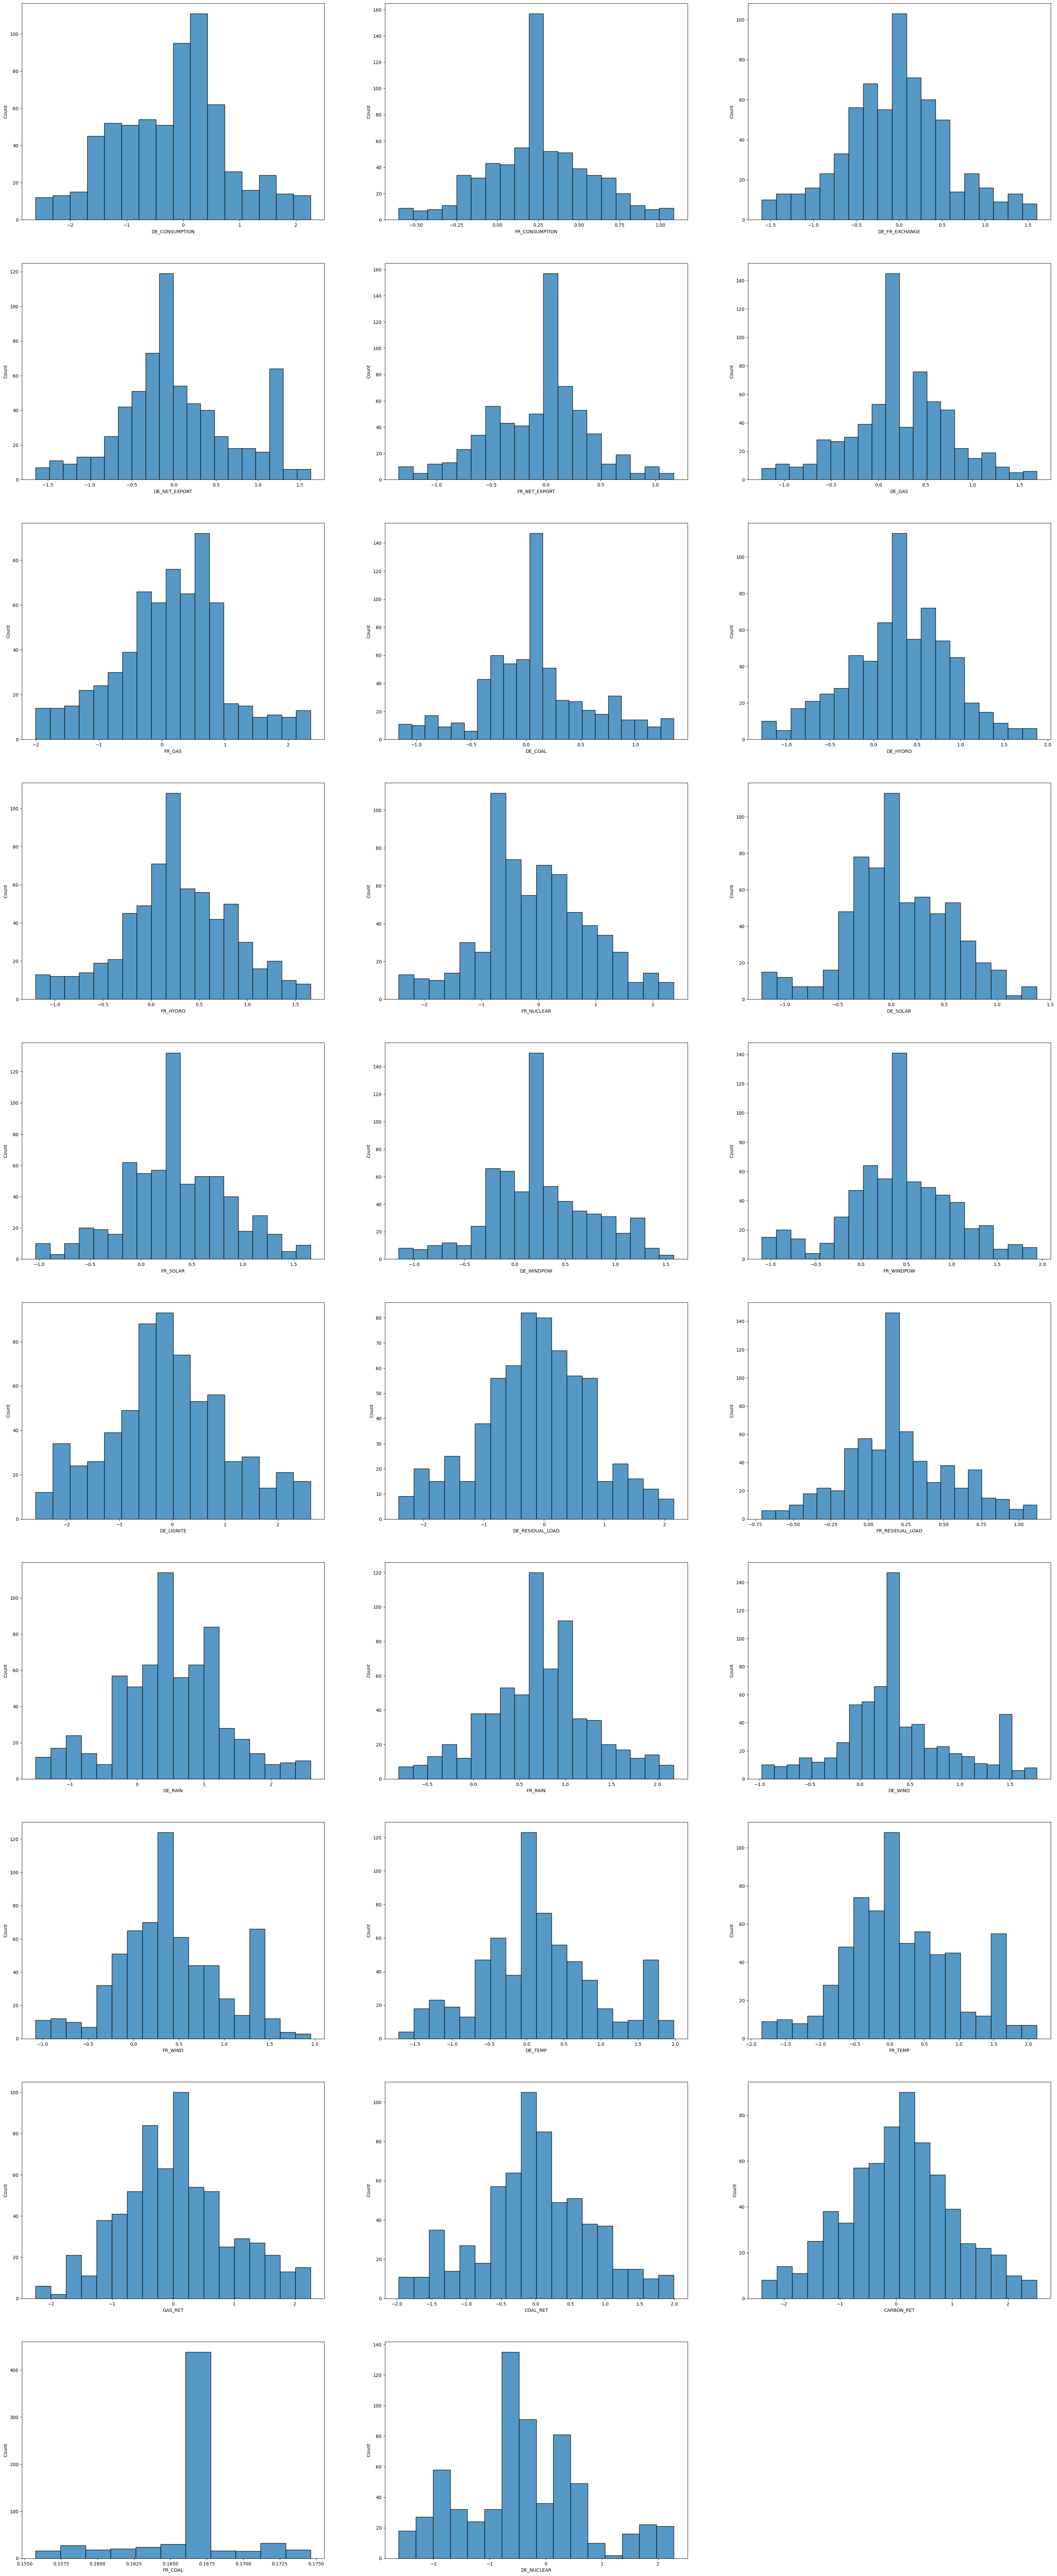

In [24]:
plt.figure(figsize=(40,100))

for i in range(len(cols)):
    plt.subplot(10,3,i+1)
    sns.histplot(x=cols[i],data=X_test_log)

In [34]:
lr=xgb.XGBRegressor(n_estimators=100,max_depth=6,learning_rate=0.2,random_state=42,reg_lambda=4)

#X_training = X_train.drop(['COUNTRY','prices'],axis=1)
#Y_training = X_train['prices']

lr.fit(X_train_log.drop('prices',axis=1), Y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [137]:
Y_test_submission['TARGET'] = lr.predict(X_test)

Y_test_submission.to_csv('qrt_lasso_0.02.csv', index=False)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 
